In [3]:
%matplotlib inline
import scipy.io
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

ModuleNotFoundError: No module named 'nipype'

In [7]:
instal nipype

SyntaxError: invalid syntax (<ipython-input-7-b866738120ae>, line 1)

In [214]:
experiment_dir = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/output'
output_dir = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/datasink'
working_dir = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/workindir'

# Smoothing withds used during preprocessing
fwhm = [4]

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0004']

mask = "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz"

In [215]:
#est = EstimateModel(estimation_method={'Classical': 1}, spm_mat_file = "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/workindir/ants_l2analysis/_contrast_id_con_0004_fwhm_id_4/onesampttestdes/SPM.mat")
#est.run() 

In [216]:
#scipy.io.loadmat("/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/workindir/ants_l2analysis/_contrast_id_con_0003_fwhm_id_4/onesampttestdes/SPM.mat", mdict=None, appendmat=True)

In [217]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

#EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

In [218]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm)]


# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(output_dir,'norm_ants', 'sub-*_fwhm{fwhm_id}', '{contrast_id}_trans.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Change the substituion parameters for the datasink
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'ants_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [219]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='ants_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])



220303-12:28:56,101 nipype.workflow INFO:
	 Generated workflow graph: /media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/workindir/ants_l2analysis/graph.png (graph2use=colored, simple_form=True).


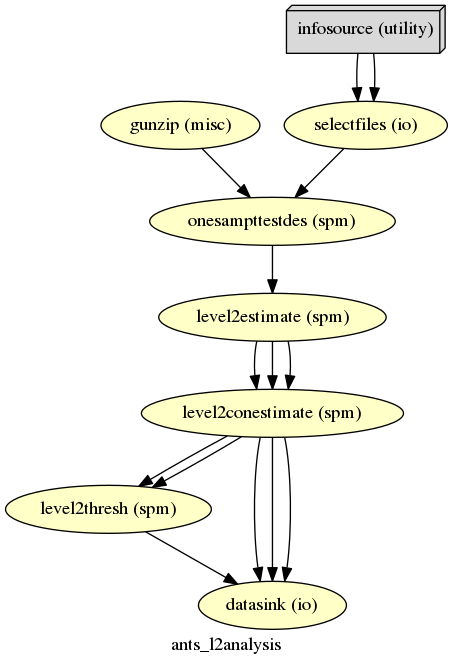

In [220]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'ants_l2analysis', 'graph.png'))

In [221]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 8})

220303-12:28:56,117 nipype.workflow INFO:
	 Workflow ants_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
220303-12:28:56,135 nipype.workflow INFO:
	 Running in parallel.
220303-12:28:56,138 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 28.21/28.21, Free processors: 8/8.
220303-12:28:56,225 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/workindir/ants_l2analysis/_contrast_id_con_0004_fwhm_id_4/selectfiles".
220303-12:28:56,226 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.gunzip" in "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/workindir/ants_l2analysis/gunzip".
220303-12:28:56,233 nipype.workflow INFO:
	 [Node] Running "gunzip" ("nipype.algorithms.misc.Gunzip")220303-12:28:56,233 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

220303-12:28:56,262 ni

/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


220303-12:29:00,143 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 28.01/28.21, Free processors: 7/8.
                     Currently running:
                       * ants_l2analysis.onesampttestdes
220303-12:29:21,532 nipype.workflow INFO:
	 [Node] Finished "ants_l2analysis.onesampttestdes".
220303-12:29:22,164 nipype.workflow INFO:
	 [Job 2] Completed (ants_l2analysis.onesampttestdes).
220303-12:29:22,166 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.21/28.21, Free processors: 8/8.
220303-12:29:22,219 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.level2estimate" in "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/workindir/ants_l2analysis/_contrast_id_con_0004_fwhm_id_4/level2estimate".
220303-12:29:22,228 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.EstimateModel")
220303-12:29:24,168 nipype.workflow INFO:
	 [MultiProc] Run

220303-12:29:46,203 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 28.21/28.21, Free processors: 8/8.
220303-12:29:48,190 nipype.workflow INFO:
	 ***********************************
220303-12:29:48,191 nipype.workflow ERROR:
	 could not run node: ants_l2analysis.level2estimate.a0
220303-12:29:48,192 nipype.workflow INFO:
	 crashfile: /home/lmn/crash-20220303-122946-lmn-level2estimate.a0-1803012d-55f9-4a97-bda8-5a5563520928.pklz
220303-12:29:48,192 nipype.workflow INFO:
	 ***********************************


RuntimeError: Workflow did not execute cleanly. Check log for details